<a href="https://colab.research.google.com/github/Elimirage/digital_image_processing_24vvim1/blob/main/lab6/LB6_DIL_Yumaeva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2 as cv
from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from scipy import ndimage
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


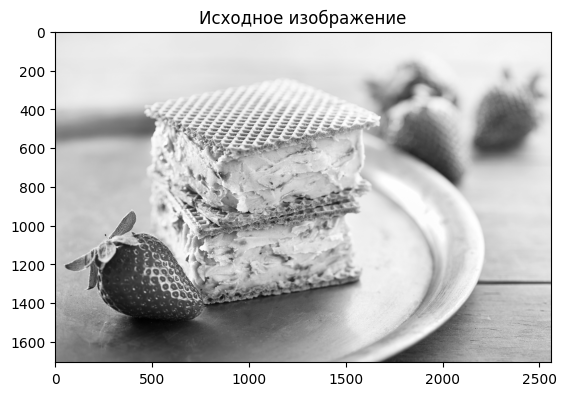

In [2]:
image = cv.imread('/content/drive/MyDrive/K47ZVgPhnc2pL5Ph9oDQwXiYSFkjyNhZaJ8YfOWuLBoA5NVgCp3zV1DSc00EwT-v0pgjecCri9QCBw326g_3mrWR.jpg')
image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)
image_hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)

gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

plt.imshow(gray, 'gray')
plt.title('Исходное изображение')
plt.show()

/tmp/ipython-input-4057664744.py:16: RuntimeWarning: overflow encountered in scalar add
  similarity = sum(abs(image[x, y, :] - image[seed_x, seed_y, :]))/3


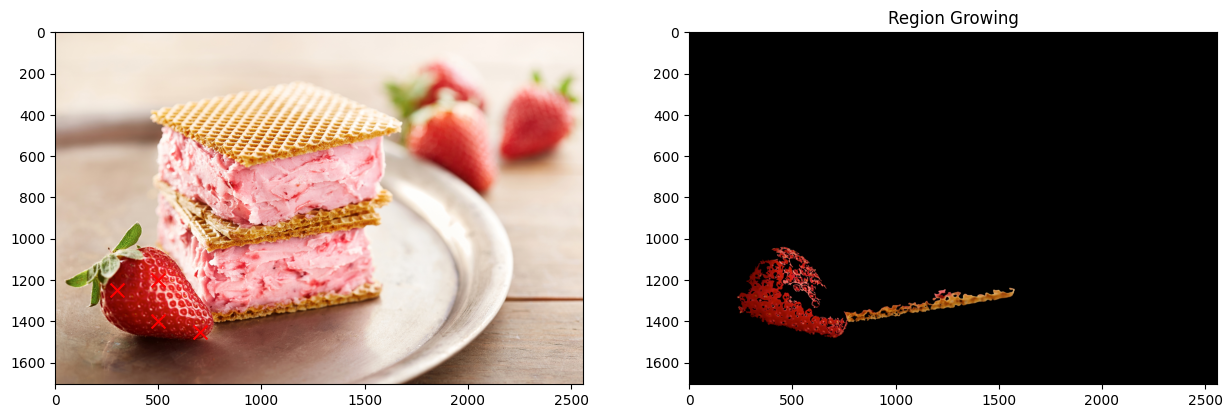

In [3]:
def region_growingHSV(image, seed, threshold):
    region_mask = np.zeros(image.shape[0:2], dtype=np.uint8)
    connectivity = [(1, 0), (-1, 0), (0, 1), (0, -1)]
    queue = []

    for i in seed:
        seed_x, seed_y = i
        queue.append((seed_x, seed_y))

        while len(queue) > 0:
            x, y = queue.pop(0)
            if x < 0 or x >= image.shape[0] or y < 0 or y >= image.shape[1]:
                continue
            if region_mask[x, y] != 0:
                continue
            similarity = sum(abs(image[x, y, :] - image[seed_x, seed_y, :]))/3
            if similarity < threshold:
                region_mask[x, y] = 255
                for dx, dy in connectivity:
                    queue.append((x + dx, y + dy))
    return region_mask

seeds = [(1400, 500), (1200, 500), (1250, 300), (1450, 700)]
x = list(map(lambda x: x[1], seeds))
y = list(map(lambda x: x[0], seeds))

threshold = 30
segmented_region = region_growingHSV(image_hsv, seeds, threshold)
result_rg = cv.bitwise_and(image, image, mask=segmented_region)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(x, y, marker="x", color="red", s=100)
plt.imshow(image_rgb)

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(result_rg, cv.COLOR_BGR2RGB))
plt.title('Region Growing')
plt.show()

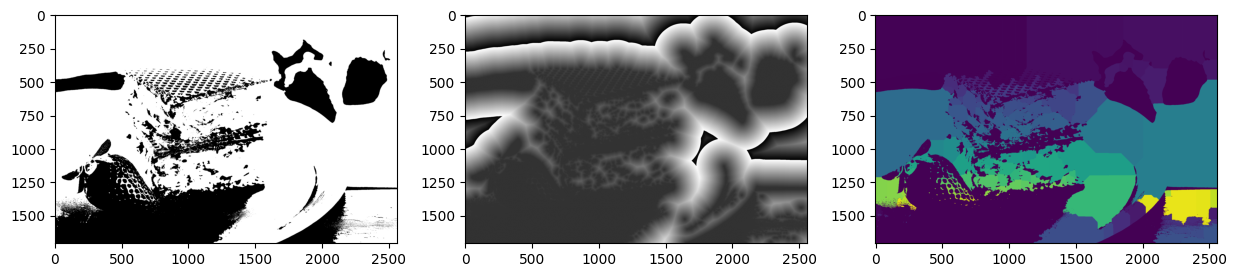

In [4]:
# Алгоритм водораздела
# Бинаризируем изображение
binary_image = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]
# Определяем карту расстояний
distance_map = ndimage.distance_transform_edt(binary_image)
# Определяем локальные максимумы
local_max = peak_local_max(distance_map, min_distance=20, labels=binary_image)
peaks_mask = np.zeros_like(distance_map, dtype=bool)
ind = np.array([i for i in local_max])
peaks_mask[ind[:,0], ind[:,1]] = True

# 4 Каждому минимуму присваивается метка и начинается заполнение бассейнов метками
markers = ndimage.label(peaks_mask, structure=np.ones((3, 3)))[0]
labels = watershed(-distance_map, markers, mask=binary_image)
# построим результаты работы алгоритма
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(binary_image, cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(np.uint8(distance_map + 50), cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(np.uint8(labels))
plt.show()

In [5]:
print(image_hsv.shape)

(1706, 2560, 3)


[[ 15]
 [178]
 [  2]
 [ 11]
 [ 29]]
[[15 15 15 ... 11 11 11]
 [15 15 15 ... 11 11 11]
 [15 15 15 ... 11 11 11]
 ...
 [11 11 11 ... 11 11 11]
 [11 11 11 ... 11 11 11]
 [11 11 11 ... 11 11 11]]


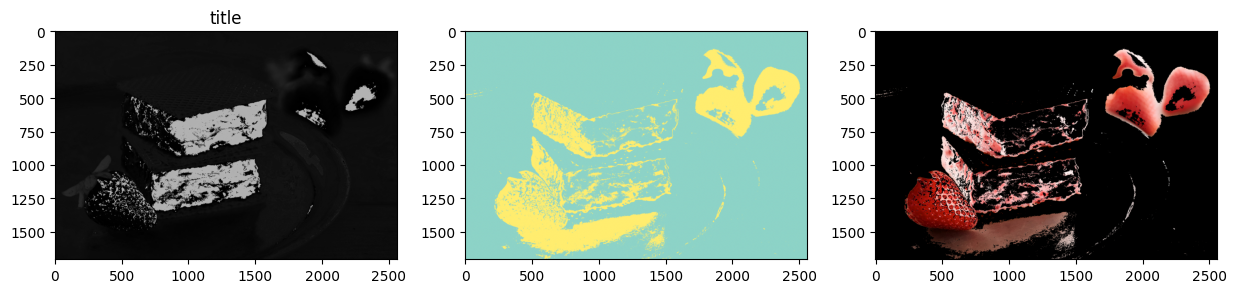

In [6]:
## Методы кластеризации. K-средних
# Преобразуем изображение в оттенках серого в одномерный массив
gray = image_hsv[:,:,0]
pixels = gray.reshape(-1, 1)
# Задаем число кластеров для сегментации
K = 5
# С помощью библиотеки sklearn.cluster import KMeans проводим кластеризацию по яркости
kmeans = KMeans(n_clusters=K, random_state=0)
labels = kmeans.fit_predict(pixels)
cluster_centers = kmeans.cluster_centers_
print (np.uint8(cluster_centers))
# Каждому пикселю назначаем значение из центра кластера
segments = np.uint8(cluster_centers[labels].reshape(gray.shape))
print(segments)
# Удалим самые темные пиксели
segments[segments!=2] = 0
result = cv.bitwise_and(image_rgb, image_rgb, mask=segments)
# Отобразим избражения
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1).set_title('title')
plt.imshow(cv.cvtColor(gray, cv.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(segments, cmap='Set3')
plt.subplot(1, 3, 3)
plt.imshow(result)
plt.show()


In [7]:
## Методы кластеризации. Сдвиг среднего (Mean shift)
# Сглаживаем чтобы уменьшить шум

blur_image = cv.medianBlur(image_hsv, 3)
# Выстраиваем пиксели в один ряд и переводим в формат с правающей точкой
flat_image = np.float32(blur_image.reshape((-1,3)))

# Используем meanshift из библиотеки sklearn
bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
ms.fit(flat_image)
labeled = ms.labels_


In [8]:
# получим количество сегментов
segments = np.unique(labeled)
print(segments)

# получим средний цвет сегмента
total = np.zeros((segments.shape[0], 3), dtype=float)
count = np.zeros(total.shape, dtype=float)
for i, label in enumerate(labeled):
    total[label] = total[label] + flat_image[i]
    count[label] += 1
avg = total/count
avg = np.uint8(avg)

[ 0  1  2  3  4  5  6  7  8  9 10]


[[ 15]
 [178]
 [  2]
 [ 11]
 [ 29]]
[[15 15 15 ... 11 11 11]
 [15 15 15 ... 11 11 11]
 [15 15 15 ... 11 11 11]
 ...
 [11 11 11 ... 11 11 11]
 [11 11 11 ... 11 11 11]
 [11 11 11 ... 11 11 11]]


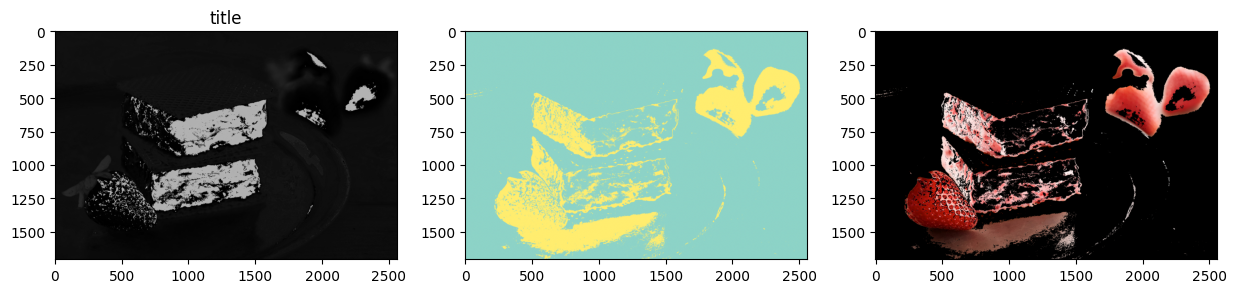

In [9]:
## Методы кластеризации. K-средних
# Преобразуем изображение в оттенках серого в одномерный массив
gray = image_hsv[:,:,0]
pixels = gray.reshape(-1, 1)
# Задаем число кластеров для сегментации
K = 5
# С помощью библиотеки sklearn.cluster import KMeans проводим кластеризацию по яркости
kmeans = KMeans(n_clusters=K, random_state=0)
labels = kmeans.fit_predict(pixels)
cluster_centers = kmeans.cluster_centers_
print (np.uint8(cluster_centers))
# Каждому пикселю назначаем значение из центра кластера
segments = np.uint8(cluster_centers[labels].reshape(gray.shape))
print(segments)
# Удалим самые темные пиксели
segments[segments!=2] = 0
result = cv.bitwise_and(image_rgb, image_rgb, mask=segments)
# Отобразим избражения
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1).set_title('title')
plt.imshow(cv.cvtColor(gray, cv.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(segments, cmap='Set3')
plt.subplot(1, 3, 3)
plt.imshow(result)
plt.show()


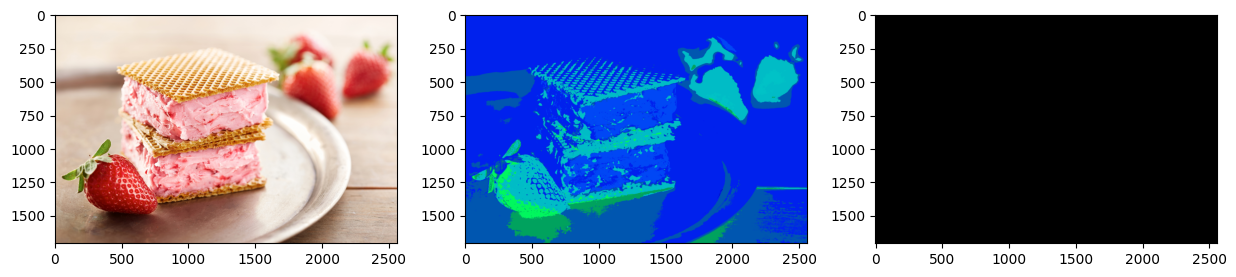

In [10]:
# Используем meanshift из библиотеки sklearn
bandwidth = estimate_bandwidth(flat_image, quantile=.06, n_samples=3000)
ms = MeanShift(bandwidth=bandwidth, max_iter=800, bin_seeding=True)
ms.fit(flat_image)
labeled = ms.labels_
# Для каждого пискеля проставим средний цвет его сегмента
mean_shift_image = avg[labeled].reshape((image.shape))
# Маской скроем один из сегментов
mask1 = mean_shift_image[:,:,0]
mask1[mask1!=2] = 0
mean_shift_with_mask_image = cv.bitwise_and(image, image, mask=mask1)
# Построим изображение
plt.figure(figsize=(15,20))
plt.subplot(1, 3, 1)
plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(mean_shift_image, cmap='Set3')
plt.subplot(1, 3, 3)
plt.imshow(cv.cvtColor(mean_shift_with_mask_image, cv.COLOR_BGR2RGB))
plt.show()